In [1]:
from ast import literal_eval
import numpy as np
import math
import re
import pandas as pd

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from difflib import SequenceMatcher
from collections import Counter
from itertools import groupby

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

# Import bo attr lookup data

In [122]:
#read in data
# df = pd.read_csv('bo_attr_lookup_data_new.csv', encoding='latin1')
df = pd.read_csv('bo_attr_lookup_new.csv', encoding='latin1')

#create spare child col
df['children_org_name'] = df['children_org_name_list'].agg(list)

#conver child col to list
df['children_org_name_list'] = df['children_org_name_list'].agg(list)

#fill missing values
df = df.fillna('missingmissingmissingmissingmissing')

#trigram function
def split_str(s, N):
    rmax = np.clip(len(s)-N, a_min=0, a_max=None)
    return [s[0+i:N+i] for i in range(0, rmax+1)]

#trigrams
df['parent_trigram'] = df['parent_org_name'].apply(lambda x: split_str(x, 3))
df['child_trigram'] = df['children_org_name_list'].apply(lambda x: split_str(x, 3))

#convert to list
df['children_org_name_list'] = df.children_org_name_list.map(lambda x: [x])

#jaro score
df['jaro_func_score'] = df[['parent_org_name', 'children_org_name_list']].agg(lambda x: get_top_matches(*x), axis=1)
df['jaro_func_score'] = df.jaro_func_score.apply(lambda x: [val[1] for val in x])
df['jaro_func_score'] = df.jaro_func_score.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)

#parent to child
df['jaro_func_score_trigram_parent'] = df[['parent_org_name', 'child_trigram']].agg(lambda x: get_top_matches(*x), axis=1)
df['jaro_func_score_trigram_parent'] = df.jaro_func_score_trigram_parent.apply(lambda x: [val[1] for val in x])

#child to parent
df['jaro_func_score_trigram_child'] = df[['children_org_name', 'parent_trigram']].agg(lambda x: get_top_matches(*x), axis=1)
df['jaro_func_score_trigram_child'] = df.jaro_func_score_trigram_child.apply(lambda x: [val[1] for val in x])

df.head(5)

,parent_org_name,children_org_name_list,match_confidence_score,match_confidence,children_org_name,parent_trigram,child_trigram,jaro_func_score,jaro_func_score_trigram_parent,jaro_func_score_trigram_child
0,"""NEXARK INC""",[NEWKIRK PRODUCTS],0.533333,LOW,NEWKIRK PRODUCTS,"[""NE, NEX, EXA, XAR, ARK, RK , K I, IN, INC, ...","[NEW, EWK, WKI, KIR, IRK, RK , K P, PR, PRO, ...",0.58,"[0.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.68, 0.6, 0.52, 0.47, 0.47, 0.47, 0.47, 0.47..."
1,+DESCONOCIDO,[DEGENKOLB],0.666667,LOW,DEGENKOLB,"[+DE, DES, ESC, SCO, CON, ONO, NOC, OCI, CID, ...","[DEG, EGE, GEN, ENK, NKO, KOL, OLB]",0.51,"[0.61, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0]","[0.7, 0.63, 0.48, 0.48, 0.0, 0.0, 0.0, 0.0, 0...."
2,+EMBOL LTDA,[EMPLOYBRIDGE],0.600000,LOW,EMPLOYBRIDGE,"[+EM, EMB, MBO, BOL, OL , L L, LT, LTD, TDA]","[EMP, MPL, PLO, LOY, OYB, YBR, BRI, RID, IDG, ...",0.63,"[0.62, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.69, 0.61, 0.47, 0.47, 0.47, 0.47, 0.0, 0.0,..."
3,+MARTINS,[SAN MARINA],0.750000,MEDIUM,SAN MARINA,"[+MA, MAR, ART, RTI, TIN, INS]","[SAN, AN , N M, MA, MAR, ARI, RIN, INA]",0.78,"[0.79, 0.64, 0.49, 0.49, 0.49, 0.49, 0.0, 0.0]","[0.84, 0.62, 0.62, 0.48, 0.48, 0.48]"
4,+RED COMUNICACAO & MARKETING LTDA,[RED ENVELOPE ENTERTAINMENT],0.625000,LOW,RED ENVELOPE ENTERTAINMENT,"[+RE, RED, ED , D C, CO, COM, OMU, MUN, UNI, ...","[RED, ED , D E, EN, ENV, NVE, VEL, ELO, LOP, ...",0.57,"[0.7, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45...","[0.79, 0.71, 0.62, 0.62, 0.58, 0.58, 0.46, 0.4..."


# Create Jaro Functions

In [8]:
#jaro version
def sort_token_alphabetically(word):
    token = re.split('[,. ]', word)
    sorted_token = sorted(token)
    return ' '.join(sorted_token)

def get_jaro_distance(first, second, winkler=True, winkler_ajustment=True,
                      scaling=0.1, sort_tokens=True):
    """
    :param first: word to calculate distance for
    :param second: word to calculate distance with
    :param winkler: same as winkler_ajustment
    :param winkler_ajustment: add an adjustment factor to the Jaro of the distance
    :param scaling: scaling factor for the Winkler adjustment
    :return: Jaro distance adjusted (or not)
    """
    if sort_tokens:
        first = sort_token_alphabetically(first)
        second = sort_token_alphabetically(second)

    if not first or not second:
        raise JaroDistanceException(
            "Cannot calculate distance from NoneType ({0}, {1})".format(
                first.__class__.__name__,
                second.__class__.__name__))

    jaro = _score(first, second)
    cl = min(len(_get_prefix(first, second)), 4)

    if all([winkler, winkler_ajustment]):  # 0.1 as scaling factor
        return round((jaro + (scaling * cl * (1.0 - jaro))) * 100.0) / 100.0

    return jaro

def _score(first, second):
    shorter, longer = first.lower(), second.lower()

    if len(first) > len(second):
        longer, shorter = shorter, longer

    m1 = _get_matching_characters(shorter, longer)
    m2 = _get_matching_characters(longer, shorter)

    if len(m1) == 0 or len(m2) == 0:
        return 0.0

    return (float(len(m1)) / len(shorter) +
            float(len(m2)) / len(longer) +
            float(len(m1) - _transpositions(m1, m2)) / len(m1)) / 3.0

def _get_diff_index(first, second):
    if first == second:
        pass

    if not first or not second:
        return 0

    max_len = min(len(first), len(second))
    for i in range(0, max_len):
        if not first[i] == second[i]:
            return i

    return max_len

def _get_prefix(first, second):
    if not first or not second:
        return ""

    index = _get_diff_index(first, second)
    if index == -1:
        return first

    elif index == 0:
        return ""

    else:
        return first[0:index]

def _get_matching_characters(first, second):
    common = []
    limit = math.floor(min(len(first), len(second)) / 2)

    for i, l in enumerate(first):
        left, right = int(max(0, i - limit)), int(
            min(i + limit + 1, len(second)))
        if l in second[left:right]:
            common.append(l)
            second = second[0:second.index(l)] + '*' + second[
                                                       second.index(l) + 1:]

    return ''.join(common)

def _transpositions(first, second):
    return math.floor(
        len([(f, s) for f, s in zip(first, second) if not f == s]) / 2.0)

def get_top_matches(reference, value_list, max_results=None):
    scores = []
    if not max_results:
        max_results = len(value_list)
    for val in value_list:
        score_sorted = get_jaro_distance(reference, val)
        score_unsorted = get_jaro_distance(reference, val, sort_tokens=False)
        scores.append((val, max(score_sorted, score_unsorted)))
    scores.sort(key=lambda x: x[1], reverse=True)

    return scores[:max_results]

class JaroDistanceException(Exception):
    def __init__(self, message):
        super(Exception, self).__init__(message)

# Apply Jaro and Sequencer function scores

In [123]:
def total_chars(row):

    results0 = []
    results1 = []
    results2 = []
    results3 = []
    results4 = []
    results5 = []
    
    p = row['parent_org_name'].lower()
    for i in row['children_org_name_list']:
        
        t = i.lower()
        
        dict1 = Counter(p)
        dict2 = Counter(t)
        
        commonDict = dict1 & dict2
        allChars = len(dict1) + len(dict2)
        childCharsPositions = len(t)
        
        results0.append((i, childCharsPositions)[1]) #totalCharacterPositions
        results1.append((i, SequenceMatcher(None, t, p).find_longest_match(0, len(t), 0, len(p))[2])[1]) #consecutiveMatchingChars
        results2.append((i, round(SequenceMatcher(None, t, p).ratio(),2))[1]) #sequence_matcher_ratio
        results3.append((i, sum(int(k==v) for k,v in zip(t, p)))[1]) #countSamePosition
        results4.append((i, allChars)[1])#countTotalUniqueChars
        results5.append((i, len(commonDict))[1]) #countCommonChars

    return pd.Series([results0, results1, results2, results3, results4, results5])

df[['total_chars_positions'
    , 'consecutive_chars'
    , 'sequence_matcher_ratio'
    , 'count_same_position'
    , 'count_total_unique_chars'
    , 'count_common_chars'
   ]]  = df.apply(total_chars, axis=1)

df['total_chars_positions'] = df.total_chars_positions.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['consecutive_chars'] = df.consecutive_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['sequence_matcher_ratio'] = df.sequence_matcher_ratio.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_same_position'] = df.count_same_position.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_total_unique_chars'] = df.count_total_unique_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)
df['count_common_chars'] = df.count_common_chars.apply(lambda x: ', '.join([str(i) for i in x])).astype(float)

df['percent_matched'] = round(df['count_common_chars'] / df['count_total_unique_chars'],2)
df['percent_same_position'] = round(df['count_same_position'] / df['total_chars_positions'],2)

df.head(10)

,parent_org_name,children_org_name_list,match_confidence_score,match_confidence,children_org_name,parent_trigram,child_trigram,jaro_func_score,jaro_func_score_trigram_parent,jaro_func_score_trigram_child,total_chars_positions,consecutive_chars,sequence_matcher_ratio,count_same_position,count_total_unique_chars,count_common_chars,percent_matched,percent_same_position
0,"""NEXARK INC""",[NEWKIRK PRODUCTS],0.533333,LOW,NEWKIRK PRODUCTS,"[""NE, NEX, EXA, XAR, ARK, RK , K I, IN, INC, ...","[NEW, EWK, WKI, KIR, IRK, RK , K P, PR, PRO, ...",0.58,"[0.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.68, 0.6, 0.52, 0.47, 0.47, 0.47, 0.47, 0.47...",16.0,3.0,0.43,3.0,24.0,7.0,0.29,0.19
1,+DESCONOCIDO,[DEGENKOLB],0.666667,LOW,DEGENKOLB,"[+DE, DES, ESC, SCO, CON, ONO, NOC, OCI, CID, ...","[DEG, EGE, GEN, ENK, NKO, KOL, OLB]",0.51,"[0.61, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0]","[0.7, 0.63, 0.48, 0.48, 0.0, 0.0, 0.0, 0.0, 0....",9.0,2.0,0.38,0.0,16.0,4.0,0.25,0.00
2,+EMBOL LTDA,[EMPLOYBRIDGE],0.600000,LOW,EMPLOYBRIDGE,"[+EM, EMB, MBO, BOL, OL , L L, LT, LTD, TDA]","[EMP, MPL, PLO, LOY, OYB, YBR, BRI, RID, IDG, ...",0.63,"[0.62, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.69, 0.61, 0.47, 0.47, 0.47, 0.47, 0.0, 0.0,...",12.0,2.0,0.35,2.0,21.0,6.0,0.29,0.17
3,+MARTINS,[SAN MARINA],0.750000,MEDIUM,SAN MARINA,"[+MA, MAR, ART, RTI, TIN, INS]","[SAN, AN , N M, MA, MAR, ARI, RIN, INA]",0.78,"[0.79, 0.64, 0.49, 0.49, 0.49, 0.49, 0.0, 0.0]","[0.84, 0.62, 0.62, 0.48, 0.48, 0.48]",10.0,3.0,0.56,0.0,15.0,6.0,0.40,0.00
4,+RED COMUNICACAO & MARKETING LTDA,[RED ENVELOPE ENTERTAINMENT],0.625000,LOW,RED ENVELOPE ENTERTAINMENT,"[+RE, RED, ED , D C, CO, COM, OMU, MUN, UNI, ...","[RED, ED , D E, EN, ENV, NVE, VEL, ELO, LOP, ...",0.57,"[0.7, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45...","[0.79, 0.71, 0.62, 0.62, 0.58, 0.58, 0.46, 0.4...",26.0,4.0,0.31,1.0,30.0,11.0,0.37,0.04
5,+TEGAPE IMPORTACAO E COMERCIO DE TECIDOS TECNI...,[ARTHUR LUNDGREN TECIDOS],0.512821,LOW,ARTHUR LUNDGREN TECIDOS,"[+TE, TEG, EGA, GAP, APE, PE , E I, IM, IMP, ...","[ART, RTH, THU, HUR, UR , R L, LU, LUN, UND, ...",0.45,"[0.57, 0.57, 0.45, 0.45, 0.45, 0.45, 0.45, 0.4...","[0.58, 0.58, 0.51, 0.51, 0.51, 0.46, 0.46, 0.4...",23.0,8.0,0.41,1.0,31.0,13.0,0.42,0.04
6,+UNDEFINEDUNDEFINEDUNDEFINED,[UNITYPOINT HEALTH],0.444444,LOW,UNITYPOINT HEALTH,"[+UN, UND, NDE, DEF, EFI, FIN, INE, NED, EDU, ...","[UNI, NIT, ITY, TYP, YPO, POI, OIN, INT, NT , ...",0.47,"[0.58, 0.46, 0.46, 0.46, 0.0, 0.0, 0.0, 0.0, 0...","[0.68, 0.68, 0.68, 0.59, 0.59, 0.59, 0.46, 0.4...",17.0,2.0,0.22,0.0,19.0,4.0,0.21,0.00
7,101 DO BRASIL INDUSTRIAL LTDA.,[FORCE 10 NETWORKS],0.433333,LOW,FORCE 10 NETWORKS,"[101, 01 , 1 D, DO, DO , O B, BR, BRA, RAS, ...","[FOR, ORC, RCE, CE , E 1, 10, 10 , 0 N, NE, ...",0.51,"[0.79, 0.79, 0.51, 0.51, 0.46, 0.46, 0.0, 0.0,...","[0.68, 0.64, 0.46, 0.46, 0.46, 0.46, 0.46, 0.4...",17.0,2.0,0.26,0.0,28.0,8.0,0.29,0.00
8,111 SOUTH,[1&1 IONOS],0.769231,MEDIUM,1&1 IONOS,"[111, 11 , 1 S, SO, SOU, OUT, UTH]","[1&1, &1 , 1 I, IO, ION, ONO, NOS]",0.67,"[0.67, 0.63, 0.53, 0.0, 0.0, 0.0, 0.0]","[0.8, 0.67, 0.53, 0.0, 0.0, 0.0, 0.0]",9.0,2.0,0.44,4.0,14.0,4.0,0.29,0.44
9,2 DESIGN E COMUNICACAO,[FRANCE 2],0.375000,LOW,FRANCE 2,"[2 D, DE, DES, ESI, SIG, IGN, GN , N E, E , ...","[FRA, RAN, ANC, NCE, CE , E 2]",0.58,"[0.67, 0.59, 0.46, 0.46, 0.0, 0.0]","[0.71, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.4...",8.0,2.0,0.20,0.0,21.0,6.0,0.29,0.00


# Create Bins columns

In [128]:
# def jaro_score_bins(df):
#     if df.jaro_func_score >= .85:
#         return 'HIGH'
#     elif df.jaro_func_score >= .55 and df.jaro_func_score < .85:
#         return 'MEDIUM'
#     else:
#         return 'LOW'
    
def jaro_score_bins(df):
    if df.jaro_func_score >= .75:
        return 'HIGH'
    else:
        return 'LOW'
    
df['jaro_score_bins'] = df.apply(jaro_score_bins, axis=1)

# def sequencer_ratio_bins(df):
#     if df.sequence_matcher_ratio >= .85:
#         return 'HIGH'
#     elif df.sequence_matcher_ratio >= .55 and df.sequence_matcher_ratio < .85:
#         return 'MEDIUM'
#     else:
#         return 'LOW'
    
def sequencer_ratio_bins(df):
    if df.sequence_matcher_ratio >= .75:
        return 'HIGH'
    else:
        return 'LOW'
    
df['sequencer_ratio_bins'] = df.apply(sequencer_ratio_bins, axis=1)

def jaro_sequencer_equal(df):
    if df['jaro_score_bins'] == df['sequencer_ratio_bins']:
        return 'EQUAL'
    else:
        return 'NOT EQUAL'
    
df['jaro_sequencer_equal'] = df.apply(jaro_sequencer_equal, axis=1)

def jaro_match_equal(df):
    if df['jaro_score_bins'] == df['match_confidence']:
        return 'EQUAL'
    else:
        return 'NOT EQUAL'

df['jaro_match_equal'] = df.apply(jaro_match_equal, axis=1)

def sequencer_match_equal(df):
    if df['sequencer_ratio_bins'] == df['match_confidence']:
        return 'EQUAL'
    else:
        return 'NOT EQUAL'

df['sequencer_match_equal'] = df.apply(sequencer_match_equal, axis=1)

def jaro_sequencer_match_equal(df):
    if df['jaro_score_bins'] == df['sequencer_ratio_bins'] and df['jaro_score_bins'] == df['match_confidence']:
        return 'EQUAL'
    else:
        return 'NOT EQUAL'

df['jaro_sequencer_match_equal'] = df.apply(jaro_sequencer_match_equal, axis=1)

df.head(10)

,parent_org_name,children_org_name_list,match_confidence_score,match_confidence,children_org_name,parent_trigram,child_trigram,jaro_func_score,jaro_func_score_trigram_parent,jaro_func_score_trigram_child,...,count_total_unique_chars,count_common_chars,percent_matched,percent_same_position,jaro_score_bins,sequencer_ratio_bins,jaro_sequencer_equal,jaro_match_equal,sequencer_match_equal,jaro_sequencer_match_equal
0,"""NEXARK INC""",[NEWKIRK PRODUCTS],0.533333,LOW,NEWKIRK PRODUCTS,"[""NE, NEX, EXA, XAR, ARK, RK , K I, IN, INC, ...","[NEW, EWK, WKI, KIR, IRK, RK , K P, PR, PRO, ...",0.58,"[0.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.68, 0.6, 0.52, 0.47, 0.47, 0.47, 0.47, 0.47...",...,24.0,7.0,0.29,0.19,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
1,+DESCONOCIDO,[DEGENKOLB],0.666667,LOW,DEGENKOLB,"[+DE, DES, ESC, SCO, CON, ONO, NOC, OCI, CID, ...","[DEG, EGE, GEN, ENK, NKO, KOL, OLB]",0.51,"[0.61, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0]","[0.7, 0.63, 0.48, 0.48, 0.0, 0.0, 0.0, 0.0, 0....",...,16.0,4.0,0.25,0.00,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
2,+EMBOL LTDA,[EMPLOYBRIDGE],0.600000,LOW,EMPLOYBRIDGE,"[+EM, EMB, MBO, BOL, OL , L L, LT, LTD, TDA]","[EMP, MPL, PLO, LOY, OYB, YBR, BRI, RID, IDG, ...",0.63,"[0.62, 0.47, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.69, 0.61, 0.47, 0.47, 0.47, 0.47, 0.0, 0.0,...",...,21.0,6.0,0.29,0.17,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
3,+MARTINS,[SAN MARINA],0.750000,MEDIUM,SAN MARINA,"[+MA, MAR, ART, RTI, TIN, INS]","[SAN, AN , N M, MA, MAR, ARI, RIN, INA]",0.78,"[0.79, 0.64, 0.49, 0.49, 0.49, 0.49, 0.0, 0.0]","[0.84, 0.62, 0.62, 0.48, 0.48, 0.48]",...,15.0,6.0,0.40,0.00,HIGH,LOW,NOT EQUAL,NOT EQUAL,NOT EQUAL,NOT EQUAL
4,+RED COMUNICACAO & MARKETING LTDA,[RED ENVELOPE ENTERTAINMENT],0.625000,LOW,RED ENVELOPE ENTERTAINMENT,"[+RE, RED, ED , D C, CO, COM, OMU, MUN, UNI, ...","[RED, ED , D E, EN, ENV, NVE, VEL, ELO, LOP, ...",0.57,"[0.7, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45...","[0.79, 0.71, 0.62, 0.62, 0.58, 0.58, 0.46, 0.4...",...,30.0,11.0,0.37,0.04,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
5,+TEGAPE IMPORTACAO E COMERCIO DE TECIDOS TECNI...,[ARTHUR LUNDGREN TECIDOS],0.512821,LOW,ARTHUR LUNDGREN TECIDOS,"[+TE, TEG, EGA, GAP, APE, PE , E I, IM, IMP, ...","[ART, RTH, THU, HUR, UR , R L, LU, LUN, UND, ...",0.45,"[0.57, 0.57, 0.45, 0.45, 0.45, 0.45, 0.45, 0.4...","[0.58, 0.58, 0.51, 0.51, 0.51, 0.46, 0.46, 0.4...",...,31.0,13.0,0.42,0.04,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
6,+UNDEFINEDUNDEFINEDUNDEFINED,[UNITYPOINT HEALTH],0.444444,LOW,UNITYPOINT HEALTH,"[+UN, UND, NDE, DEF, EFI, FIN, INE, NED, EDU, ...","[UNI, NIT, ITY, TYP, YPO, POI, OIN, INT, NT , ...",0.47,"[0.58, 0.46, 0.46, 0.46, 0.0, 0.0, 0.0, 0.0, 0...","[0.68, 0.68, 0.68, 0.59, 0.59, 0.59, 0.46, 0.4...",...,19.0,4.0,0.21,0.00,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
7,101 DO BRASIL INDUSTRIAL LTDA.,[FORCE 10 NETWORKS],0.433333,LOW,FORCE 10 NETWORKS,"[101, 01 , 1 D, DO, DO , O B, BR, BRA, RAS, ...","[FOR, ORC, RCE, CE , E 1, 10, 10 , 0 N, NE, ...",0.51,"[0.79, 0.79, 0.51, 0.51, 0.46, 0.46, 0.0, 0.0,...","[0.68, 0.64, 0.46, 0.46, 0.46, 0.46, 0.46, 0.4...",...,28.0,8.0,0.29,0.00,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL
8,111 SOUTH,[1&1 IONOS],0.769231,MEDIUM,1&1 IONOS,"[111, 11 , 1 S, SO, SOU, OUT, UTH]","[1&1, &1 , 1 I, IO, ION, ONO, NOS]",0.67,"[0.67, 0.63, 0.53, 0.0, 0.0, 0.0, 0.0]","[0.8, 0.67, 0.53, 0.0, 0.0, 0.0, 0.0]",...,14.0,4.0,0.29,0.44,LOW,LOW,EQUAL,NOT EQUAL,NOT EQUAL,NOT EQUAL
9,2 DESIGN E COMUNICACAO,[FRANCE 2],0.375000,LOW,FRANCE 2,"[2 D, DE, DES, ESI, SIG, IGN, GN , N E, E , ...","[FRA, RAN, ANC, NCE, CE , E 2]",0.58,"[0.67, 0.59, 0.46, 0.46, 0.0, 0.0]","[0.71, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.4...",...,21.0,6.0,0.29,0.00,LOW,LOW,EQUAL,EQUAL,EQUAL,EQUAL


In [129]:
Jaro_and_Sequencer_Bins = df['jaro_sequencer_equal'].value_counts()
Jaro_Sequencer_and_Match_Bins = df['jaro_sequencer_match_equal'].value_counts()
Jaro_Match_Bins = df['jaro_match_equal'].value_counts()
Sequencer_Match_Bins = df['sequencer_match_equal'].value_counts()

print('Jaro and Sequencer Bins: ')
print(df['jaro_sequencer_equal'].value_counts())
print('')
print('Jaro, Sequencer and Match Bins: ')
print(df['jaro_sequencer_match_equal'].value_counts())
print('')
print('Match Confidence Bins: ')
print(df['match_confidence'].value_counts())
print('')
print('Jaro Score Bins: ')
print(df['jaro_score_bins'].value_counts())
print('')
print('Sequencer Ratio Bins: ')
print(df['sequencer_ratio_bins'].value_counts())
print('')
print('Jaro Match Bins: ')
print(df['jaro_match_equal'].value_counts())
print('')
print('Sequencer Match Bins: ')
print(df['sequencer_match_equal'].value_counts())
print('')

Jaro and Sequencer Bins: 
EQUAL        9838
NOT EQUAL    6172
Name: jaro_sequencer_equal, dtype: int64

Jaro, Sequencer and Match Bins: 
EQUAL        8797
NOT EQUAL    7213
Name: jaro_sequencer_match_equal, dtype: int64

Match Confidence Bins: 
LOW       12726
MEDIUM     1857
HIGH       1353
HIGH-1       74
Name: match_confidence, dtype: int64

Jaro Score Bins: 
LOW     8279
HIGH    7731
Name: jaro_score_bins, dtype: int64

Sequencer Ratio Bins: 
LOW     14409
HIGH     1601
Name: sequencer_ratio_bins, dtype: int64

Jaro Match Bins: 
EQUAL        9103
NOT EQUAL    6907
Name: jaro_match_equal, dtype: int64

Sequencer Match Bins: 
EQUAL        13488
NOT EQUAL     2522
Name: sequencer_match_equal, dtype: int64



# Visualize Match Confidence, Jaro and Sequencer Breakdown

In [130]:
jsb_values = Jaro_and_Sequencer_Bins.values
jsbm_values = Jaro_Sequencer_and_Match_Bins
sm_values = Sequencer_Match_Bins
jm_values = Jaro_Match_Bins

labels = ['NOT EQUAL','EQUAL']
values1 = jsb_values
values2 = jsbm_values
values3 = sm_values
values4 = jm_values

colors = ['darkblue', 'lightcyan']

fig = make_subplots(rows=1
                    , cols=4
                    , specs=[[{'type':'domain'}
                            , {'type':'domain'}
                            , {'type':'domain'}
                            , {'type':'domain'}]]
                    ,subplot_titles=['JS'
                                   , 'JSM'
                                   , 'SM'
                                   , 'JM'])

fig.add_trace(go.Pie(labels=labels
                     , values=values1
                     , textinfo='text+label+value+percent'
                     , name="Jaro_and_Sequencer_Bins"
                    ), 1, 1)
fig.add_trace(go.Pie(labels=labels
                     , values=values2
                     , textinfo='text+label+value+percent'
                     , name="Jaro_Sequencer_and_Match_Bins"
                    ), 1, 2)
fig.add_trace(go.Pie(labels=labels
                     , values=values3
                     , textinfo='text+label+value+percent'
                     , name="Sequencer_Match_Bins"
                    ), 1, 3)
fig.add_trace(go.Pie(labels=labels
                     , values=values4
                     , textinfo='text+label+value+percent'
                     , name="Jaro_Match_Bins"
                    ), 1, 4)

# fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(textposition='inside'
                 , textinfo='text+label+value+percent'
                 , marker=dict(colors=colors)
                 )

fig.update_layout(
    legend={'traceorder':'normal'}
#     , title_text='Jaro and Sequencer Bins'
)

fig.show()

In [88]:
del(df2)

# Create new df for Machine learning

In [89]:
df2 = df[['jaro_func_score' #0
    , 'total_chars_positions' #1
    , 'consecutive_chars'     #2
    , 'sequence_matcher_ratio'#3
    , 'count_same_position'   #4
    , 'count_total_unique_chars' #5
    , 'count_common_chars'       #6
    , 'percent_matched'          #7
    , 'percent_same_position'    #8
    , 'jaro_func_score_trigram_parent' #9
    , 'jaro_func_score_trigram_child'  #10
    , 'match_confidence_score'         #11
    , 'match_confidence'               #12
    , 'jaro_score_bins'                #13
    , 'sequencer_ratio_bins'           #14
    , 'jaro_sequencer_equal'           #15
    , 'jaro_sequencer_match_equal'     #16
   ]]

df2.head()

,jaro_func_score,total_chars_positions,consecutive_chars,sequence_matcher_ratio,count_same_position,count_total_unique_chars,count_common_chars,percent_matched,percent_same_position,jaro_func_score_trigram_parent,jaro_func_score_trigram_child,match_confidence_score,match_confidence,jaro_score_bins,sequencer_ratio_bins,jaro_sequencer_equal,jaro_sequencer_match_equal
0,0.73,21.0,4.0,0.30,4.0,20.0,5.0,0.25,0.19,"[0.82, 0.78, 0.52, 0.52, 0.52, 0.47, 0.47, 0.4...","[0.8, 0.74, 0.46, 0.46, 0.0, 0.0, 0.0, 0.0, 0....",0.9,HIGH,MEDIUM,LOW,NOT EQUAL,NOT EQUAL
1,0.46,7.0,4.0,0.39,0.0,24.0,6.0,0.25,0.00,"[0.51, 0.51, 0.46, 0.0, 0.0]","[0.87, 0.81, 0.65, 0.54, 0.0, 0.0, 0.0, 0.0, 0...",0.9,HIGH,LOW,LOW,EQUAL,NOT EQUAL
2,0.82,5.0,5.0,0.21,5.0,22.0,5.0,0.23,1.00,"[0.78, 0.69, 0.0]","[0.91, 0.87, 0.75, 0.69, 0.56, 0.52, 0.51, 0.5...",0.9,HIGH,MEDIUM,LOW,NOT EQUAL,NOT EQUAL
3,0.83,5.0,5.0,0.29,5.0,20.0,5.0,0.25,1.00,"[0.79, 0.7, 0.0]","[0.91, 0.87, 0.56, 0.56, 0.51, 0.51, 0.51, 0.5...",0.9,HIGH,MEDIUM,LOW,NOT EQUAL,NOT EQUAL
4,0.75,23.0,4.0,0.32,4.0,23.0,8.0,0.35,0.17,"[0.81, 0.73, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8, 0.71, 0.51, 0.46, 0.46, 0.46, 0.46, 0.46...",0.9,HIGH,MEDIUM,LOW,NOT EQUAL,NOT EQUAL


In [90]:
def jaro_prediction(row):
    if row['jaro_score_bins'] == 'HIGH':
        return '2'
    elif row['jaro_score_bins'] == 'MEDIUM':
        return '1'
    elif row['jaro_score_bins'] == 'LOW':
        return '0'

df2['jaro_prediction'] = df2.apply(jaro_prediction, axis=1)

def sequencer_prediction(row):
    if row['sequencer_ratio_bins'] == 'HIGH':
        return '2'
    elif row['sequencer_ratio_bins'] == 'MEDIUM':
        return '1'
    elif row['sequencer_ratio_bins'] == 'LOW':
        return '0'

df2['sequencer_prediction'] = df2.apply(sequencer_prediction, axis=1)

def match_prediction(row):
    if row['match_confidence'] == 'HIGH':
        return '2'
    elif row['match_confidence'] == 'MEDIUM':
        return '1'
    elif row['match_confidence'] == 'LOW':
        return '0'

df2['Prediction'] = df2.apply(match_prediction, axis=1)
df2['match_confidence'] = df2.apply(match_prediction, axis=1)

def jaro_score_bins(row):
    if row['jaro_score_bins'] == 'HIGH':
        return '2'
    elif row['jaro_score_bins'] == 'MEDIUM':
        return '1'
    elif row['jaro_score_bins'] == 'LOW':
        return '0'
    
df2['jaro_score_bins'] = df2.apply(jaro_score_bins, axis=1)

def sequencer_ratio_bins(row):
    if row['sequencer_ratio_bins'] == 'HIGH':
        return '2'
    elif row['sequencer_ratio_bins'] == 'MEDIUM':
        return '1'
    elif row['sequencer_ratio_bins'] == 'LOW':
        return '0'

df2['sequencer_ratio_bins'] = df2.apply(sequencer_ratio_bins, axis=1)

def jaro_sequencer_equal(row):
    if row['jaro_sequencer_equal'] == 'NOT EQUAL':
        return '0'
    elif row['jaro_sequencer_equal'] == 'EQUAL':
        return '1'

df2['jaro_sequencer_equal'] = df2.apply(jaro_sequencer_equal, axis=1)

def jaro_sequencer_match_equal(row):
    if row['jaro_sequencer_match_equal'] == 'NOT EQUAL':
        return '0'
    elif row['jaro_sequencer_match_equal'] == 'EQUAL':
        return '1'

df2['jaro_sequencer_match_equal'] = df2.apply(jaro_sequencer_match_equal, axis=1)

df2.head()

,jaro_func_score,total_chars_positions,consecutive_chars,sequence_matcher_ratio,count_same_position,count_total_unique_chars,count_common_chars,percent_matched,percent_same_position,jaro_func_score_trigram_parent,jaro_func_score_trigram_child,match_confidence_score,match_confidence,jaro_score_bins,sequencer_ratio_bins,jaro_sequencer_equal,jaro_sequencer_match_equal,jaro_prediction,sequencer_prediction,Prediction
0,0.73,21.0,4.0,0.30,4.0,20.0,5.0,0.25,0.19,"[0.82, 0.78, 0.52, 0.52, 0.52, 0.47, 0.47, 0.4...","[0.8, 0.74, 0.46, 0.46, 0.0, 0.0, 0.0, 0.0, 0....",0.9,2,1,0,0,0,1,0,2
1,0.46,7.0,4.0,0.39,0.0,24.0,6.0,0.25,0.00,"[0.51, 0.51, 0.46, 0.0, 0.0]","[0.87, 0.81, 0.65, 0.54, 0.0, 0.0, 0.0, 0.0, 0...",0.9,2,0,0,1,0,0,0,2
2,0.82,5.0,5.0,0.21,5.0,22.0,5.0,0.23,1.00,"[0.78, 0.69, 0.0]","[0.91, 0.87, 0.75, 0.69, 0.56, 0.52, 0.51, 0.5...",0.9,2,1,0,0,0,1,0,2
3,0.83,5.0,5.0,0.29,5.0,20.0,5.0,0.25,1.00,"[0.79, 0.7, 0.0]","[0.91, 0.87, 0.56, 0.56, 0.51, 0.51, 0.51, 0.5...",0.9,2,1,0,0,0,1,0,2
4,0.75,23.0,4.0,0.32,4.0,23.0,8.0,0.35,0.17,"[0.81, 0.73, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.8, 0.71, 0.51, 0.46, 0.46, 0.46, 0.46, 0.46...",0.9,2,1,0,0,0,1,0,2


In [91]:
for i in enumerate(df2.columns):
    print(i)

(0, 'jaro_func_score')
(1, 'total_chars_positions')
(2, 'consecutive_chars')
(3, 'sequence_matcher_ratio')
(4, 'count_same_position')
(5, 'count_total_unique_chars')
(6, 'count_common_chars')
(7, 'percent_matched')
(8, 'percent_same_position')
(9, 'jaro_func_score_trigram_parent')
(10, 'jaro_func_score_trigram_child')
(11, 'match_confidence_score')
(12, 'match_confidence')
(13, 'jaro_score_bins')
(14, 'sequencer_ratio_bins')
(15, 'jaro_sequencer_equal')
(16, 'jaro_sequencer_match_equal')
(17, 'jaro_prediction')
(18, 'sequencer_prediction')
(19, 'Prediction')


In [101]:
match_X = df2[df2.columns[0:16]].values

X = df2[df2.columns[0:8]].values
y = df2[df2.columns[17]].values
jaro_y = df2[df2.columns[15]].values
sequencer_y = df2[df2.columns[16]].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(match_X, y, test_size=0.9)
jaro_X_train, jaro_X_test, jaro_y_train, jaro_y_test = model_selection.train_test_split(X, jaro_y, test_size=0.9)
sequencer_X_train, sequencer_X_test, sequencer_y_train, sequencer_y_test = model_selection.train_test_split(X, sequencer_y, test_size=0.9)

print('Jaro Prediction: \n', df2.jaro_prediction.value_counts())
print('Sequencer Prediction: \n', df2.sequencer_prediction.value_counts())
print('Match Prediction: \n', df2.Prediction.value_counts())
print('')
print('X_train shape: \n', X_train.shape)
print('X_test shape: \n', X_test.shape)
print('y_train shape: \n', y_train.shape)
print('y_test shape: \n', y_test.shape)
print('')
print('x_train:',X_train)
print('y_train:',y_train)
print('x_test:',X_test)
print('y_test:',y_test)

Jaro Prediction: 
 2    371
1    278
0      9
Name: jaro_prediction, dtype: int64
Sequencer Prediction: 
 1    481
0    146
2     31
Name: sequencer_prediction, dtype: int64
Match Prediction: 
 0    494
2    164
Name: Prediction, dtype: int64

X_train shape: 
 (65, 16)
X_test shape: 
 (593, 16)
y_train shape: 
 (65,)
y_test shape: 
 (593,)

x_train: [[0.92 7.0 6.0 ... '2' '1' '0']
 [0.87 31.0 13.0 ... '2' '1' '0']
 [0.86 5.0 5.0 ... '2' '0' '0']
 ...
 [0.78 11.0 6.0 ... '1' '1' '1']
 [0.79 8.0 4.0 ... '1' '0' '0']
 [0.82 12.0 3.0 ... '1' '1' '1']]
y_train: ['2' '2' '2' '2' '2' '2' '2' '1' '1' '2' '2' '2' '2' '1' '2' '2' '1' '2'
 '1' '1' '2' '1' '1' '2' '2' '1' '2' '2' '1' '2' '1' '2' '1' '2' '2' '2'
 '1' '2' '2' '1' '1' '2' '2' '2' '2' '1' '2' '2' '1' '2' '2' '1' '1' '2'
 '1' '1' '1' '2' '2' '2' '2' '2' '1' '1' '1']
x_test: [[0.88 12.0 4.0 ... '2' '1' '0']
 [0.94 11.0 11.0 ... '2' '1' '0']
 [0.88 36.0 11.0 ... '2' '1' '0']
 ...
 [0.88 9.0 5.0 ... '2' '1' '0']
 [0.96 4.0 4.0 ... '2' '2'

# Create Classifiers and Confusion Matrices for Each Dataset

In [102]:
#Match Confidence Classifiers
#logistic regression classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

print('LR Confusion Matrix: \n', confusion_matrix(y_test, lr_predictions))
# print('LR y_pred_class: \n', y_pred_class)
print('LR Accuracy Score: ', accuracy_score(y_test, lr_predictions))

print('')

#random forest classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
# print('rfc score train: ',rfc.score(X_train, y_train))
# print('rfc score test: ',rfc.score(X_test, y_test))
print('RFC Confusion Matrix: \n', confusion_matrix(y_test, rfc_predictions))
print('RFC Accuracy Score: ', accuracy_score(y_test, rfc_predictions))

print('')

#knn classifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

print('KNN Confusion Matrix: \n', confusion_matrix(y_test, knn_predictions))
# print('knn_predictions: \n',knn_predictions)
print('KNN Accuracy Score: ', accuracy_score(y_test, knn_predictions))

print('')

#svc classifier
svc = SVC(C=1.0)
svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)
# print('svc score train: ',svc.score(X_train, y_train))
# print('svc score test: ',svc.score(X_test, y_test))
print('SVC Confusion Matrix: \n', confusion_matrix(y_test, svc_predictions))
print('SVC Accuracy Score: ', accuracy_score(y_test, svc_predictions))

ValueError: setting an array element with a sequence.

In [103]:
#Jaro Classifiers
#logistic regression classifier
lr = LogisticRegression()
lr.fit(jaro_X_train, jaro_y_train)
lr_predictions = lr.predict(jaro_X_test)

print('LR Confusion Matrix: \n', confusion_matrix(jaro_y_test, lr_predictions))
# print('LR y_pred_class: \n', y_pred_class)
print('LR Accuracy Score: ', accuracy_score(jaro_y_test, lr_predictions))

print('')

#random forest classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(jaro_X_train, jaro_y_train)
rfc_predictions = rfc.predict(jaro_X_test)
# print('rfc score train: ',rfc.score(jaro_X_train, jaro_y_train))
# print('rfc score test: ',rfc.score(jaro_X_test, jaro_y_test))
print('RFC Confusion Matrix: \n', confusion_matrix(jaro_y_test, rfc_predictions))
print('RFC Accuracy Score: ', accuracy_score(jaro_y_test, rfc_predictions))

print('')

#knn classifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(jaro_X_train, jaro_y_train)
knn_predictions = knn.predict(jaro_X_test)

print('KNN Confusion Matrix: \n', confusion_matrix(jaro_y_test, knn_predictions))
# print('knn_predictions: \n',knn_predictions)
print('KNN Accuracy Score: ', accuracy_score(jaro_y_test, knn_predictions))

print('')

#svc classifier
svc = SVC(C=1.0)
svc.fit(jaro_X_train, jaro_y_train)
svc_predictions = svc.predict(jaro_X_test)
# print('svc score train: ',svc.score(jaro_X_train, jaro_y_train))
# print('svc score test: ',svc.score(jaro_X_test, jaro_y_test))
print('SVC Confusion Matrix: \n', confusion_matrix(jaro_y_test, svc_predictions))
print('SVC Accuracy Score: ', accuracy_score(jaro_y_test, svc_predictions))

LR Confusion Matrix: 
 [[410  17]
 [125  41]]
LR Accuracy Score:  0.760539629005059

RFC Confusion Matrix: 
 [[414  13]
 [ 17 149]]
RFC Accuracy Score:  0.9494097807757167

KNN Confusion Matrix: 
 [[388  39]
 [129  37]]
KNN Accuracy Score:  0.7166947723440135

SVC Confusion Matrix: 
 [[422   5]
 [164   2]]
SVC Accuracy Score:  0.715008431703204


In [104]:
#Sequencer Ratio Classifiers
#logistic regression classifier
lr = LogisticRegression()
lr.fit(sequencer_X_train, sequencer_y_train)
lr_predictions = lr.predict(sequencer_X_test)

print('LR Confusion Matrix: \n', confusion_matrix(sequencer_y_test, lr_predictions))
# print('LR y_pred_class: \n', y_pred_class)
print('LR Accuracy Score: ', accuracy_score(sequencer_y_test, lr_predictions))

print('')

#random forest classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(sequencer_X_train, sequencer_y_train)
rfc_predictions = rfc.predict(sequencer_X_test)
# print('rfc score train: ',rfc.score(sequencer_X_train, sequencer_y_train))
# print('rfc score test: ',rfc.score(sequencer_X_test, sequencer_y_test))
print('RFC Confusion Matrix: \n', confusion_matrix(sequencer_y_test, rfc_predictions))
print('RFC Accuracy Score: ', accuracy_score(sequencer_y_test, rfc_predictions))

print('')

#knn classifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(sequencer_X_train, sequencer_y_train)
knn_predictions = knn.predict(sequencer_X_test)

print('KNN Confusion Matrix: \n', confusion_matrix(sequencer_y_test, knn_predictions))
# print('knn_predictions: \n',knn_predictions)
print('KNN Accuracy Score: ', accuracy_score(sequencer_y_test, knn_predictions))

print('')

#svc classifier
svc = SVC(C=1.0)
svc.fit(sequencer_X_train, sequencer_y_train)
svc_predictions = svc.predict(sequencer_X_test)
# print('svc score train: ',svc.score(sequencer_X_train, sequencer_y_train))
# print('svc score test: ',svc.score(sequencer_X_test, sequencer_y_test))
print('SVC Confusion Matrix: \n', confusion_matrix(sequencer_y_test, svc_predictions))
print('SVC Accuracy Score: ', accuracy_score(sequencer_y_test, svc_predictions))

LR Confusion Matrix: 
 [[574   4]
 [ 10   5]]
LR Accuracy Score:  0.9763912310286678

RFC Confusion Matrix: 
 [[577   1]
 [ 10   5]]
RFC Accuracy Score:  0.9814502529510961

KNN Confusion Matrix: 
 [[578   0]
 [ 15   0]]
KNN Accuracy Score:  0.9747048903878583

SVC Confusion Matrix: 
 [[578   0]
 [ 15   0]]
SVC Accuracy Score:  0.9747048903878583


# Create Confusion Matrices

In [85]:
#classification report function and classifiers
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
        y_true=y_test
        , y_pred=y_predictions
        , labels=np.unique(y_pred)
    )

    avg = list(precision_recall_fscore_support(
            y_true=y_test, 
            y_pred=y_predictions,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

classifiers = {
    "Naive Bayes": GaussianNB(),
    "LogisiticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
}

Classification Report: 



ValueError: setting an array element with a sequence.

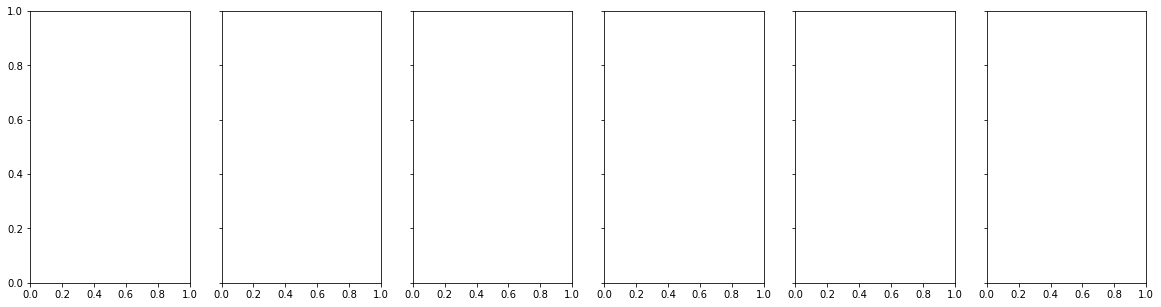

In [105]:
import warnings
warnings.filterwarnings('always')

f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')

print('Classification Report: \n')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    y_predictions = classifier.predict(X_test)
    df_class_report = pandas_classification_report(y_true=y_test, y_pred=y_predictions)
    print((classifier),'\n',df_class_report)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                   display_labels=)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        
f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

Jaro Score Classification Report: 

GaussianNB() 
              precision    recall  f1-score  support
0             0.008000  0.444444  0.015717      9.0
1             0.408602  0.150198  0.219653    253.0
avg / total   0.174449  0.070826  0.093952    262.0
LogisticRegression() 
              precision    recall  f1-score  support
0             0.013084  0.777778  0.025735      9.0
1             0.448276  0.102767  0.167203    253.0
avg / total   0.191453  0.055649  0.071727    262.0
DecisionTreeClassifier() 
              precision    recall  f1-score  support
0             0.014388  0.666667  0.028169      9.0
1             0.448864  0.312253  0.368298    253.0
avg / total   0.191723  0.143339  0.157560    262.0


/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and bei

RandomForestClassifier() 
              precision    recall  f1-score  support
0             0.013825  0.666667  0.027088      9.0
1             0.446541  0.280632  0.344660    253.0
avg / total   0.190724  0.129848  0.147458    262.0
KNeighborsClassifier() 
              precision    recall  f1-score  support
0             0.014523  0.777778  0.028513      9.0
1             0.504505  0.221344  0.307692    253.0
avg / total   0.215464  0.106239  0.131708    262.0
SVC() 
              precision    recall  f1-score  support
0             0.015358  1.000000  0.030252      9.0
1             0.428571  0.011858  0.023077    253.0
avg / total   0.183081  0.020236  0.010305    262.0


/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



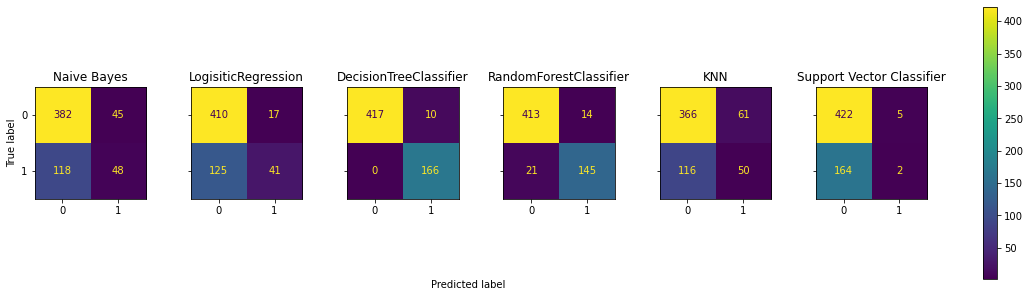

In [106]:
f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')

print('Jaro Score Classification Report: \n')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(jaro_X_train, jaro_y_train).predict(jaro_X_test)
    y_predictions = classifier.predict(jaro_X_test)
    df_class_report = pandas_classification_report(y_true=jaro_y_test, y_pred=y_predictions)
    print((classifier),'\n', df_class_report)
    cf_matrix = confusion_matrix(jaro_y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                   display_labels=)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        
f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

Sequencer Ratio Model Classification Report: 

GaussianNB() 
              precision    recall  f1-score  support
0             0.015437  1.000000  0.030405      9.0
1             0.500000  0.019763  0.038023    253.0
avg / total   0.213556  0.023609  0.016684    262.0
LogisticRegression() 
              precision    recall  f1-score  support
0             0.015411  1.000000  0.030354      9.0
1             0.555556  0.019763  0.038168    253.0
avg / total   0.237258  0.023609  0.016745    262.0
DecisionTreeClassifier() 
              precision    recall  f1-score  support
0             0.015491  1.000000  0.030508      9.0
1             0.416667  0.019763  0.037736    253.0
avg / total   0.178004  0.023609  0.016563    262.0


/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/acc48668/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and bei

RandomForestClassifier() 
              precision    recall  f1-score  support
0             0.015358  1.000000  0.030252      9.0
1             0.285714  0.007905  0.015385    253.0
avg / total   0.122131  0.018550  0.007023    262.0
KNeighborsClassifier() 
              precision    recall  f1-score  support
0             0.015177  1.000000  0.029900      9.0
avg / total   0.000230  0.015177  0.000454      9.0
SVC() 
              precision    recall  f1-score  support
0             0.015177  1.000000  0.029900      9.0
avg / total   0.000230  0.015177  0.000454      9.0


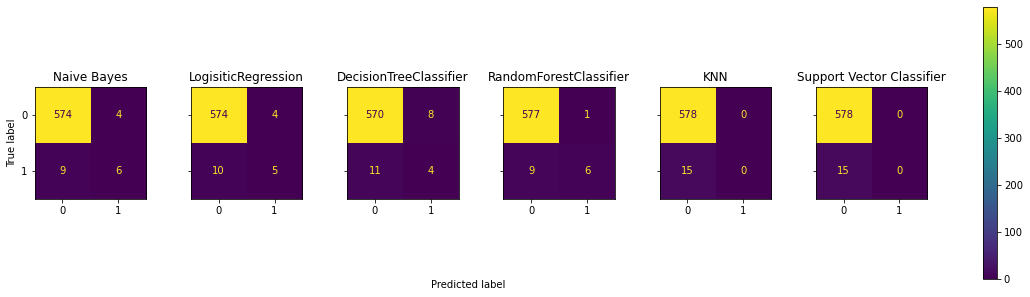

In [107]:
f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')

print('Sequencer Ratio Model Classification Report: \n')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(sequencer_X_train, sequencer_y_train).predict(sequencer_X_test)
    y_predictions = classifier.predict(sequencer_X_test)
    df_class_report = pandas_classification_report(y_true=sequencer_y_test, y_pred=y_predictions)
    print((classifier),'\n', df_class_report)
    cf_matrix = confusion_matrix(sequencer_y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                   display_labels=)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        
f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

# Test Code

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(20, 5), sharey='row')

matrix = plot_confusion_matrix(lr, X_test, y_test)
matrix.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()

matrix1 = plot_confusion_matrix(knn, X_test, y_test)
matrix1.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()
print('Accuracy of the knn algorithm is: {}'.format(accuracy_score(y_test, knn_predictions)))
print('')
print('Confusion Matrix: \n', confusion_matrix(y_test, knn_predictions))

In [ ]:
for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    y_predictions = classifier.predict(X_test)
#     print((classifier), classification_report(y_true=y_test, y_pred=y_predictions, digits=2))
    df_class_report = pandas_classification_report(y_true=y_test, y_pred=y_predictions)
    print((classifier),'\n',df_class_report)

    table = []
    f1 = list(f1_score(y_test, y_pred, average="macro"))
    print((classifier),':'
          , 'f1_score:', (round(f1_score(y_test, y_pred, average="macro"),2))
          , 'precision_score:', (round(precision_score(y_test, y_predictions, average="macro"),2))
          , 'recall_score:', (round(recall_score(y_test, y_predictions, average="macro"),2))
          , 'accuracy_score:', (round(accuracy_score(y_test, y_predictions),2))
#           , 'support:', (round(support(y_test, y_predictions),2))
         )

In [ ]:
matrix = plot_confusion_matrix(lr, X_test, y_test)
matrix.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()
print('Accuracy of the lr algorithm is: {}'.format(accuracy_score(y_test, lr_predictions)))
print('Confusion Matrix: \n', confusion_matrix(y_test, lr_predictions))

matrix1 = plot_confusion_matrix(rfc, X_test, y_test)
matrix1.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()
print('Accuracy of the rfc algorithm is: {}'.format(accuracy_score(y_test, rfc_predictions)))
print('Confusion Matrix: \n', confusion_matrix(y_test, rfc_predictions))

matrix = plot_confusion_matrix(knn, X_test, y_test)
matrix.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()
print('Accuracy of the knn algorithm is: {}'.format(accuracy_score(y_test, knn_predictions)))
print('Confusion Matrix: \n', confusion_matrix(y_test, knn_predictions))

matrix = plot_confusion_matrix(svc, X_test, y_test)
matrix.ax_.set_title('Confusion Matrix',color='white')
plt.xlabel('Predicted Label', color='white')
plt.ylabel('True Label', color='white')
plt.gcf().axes[0].tick_params(color='white')
plt.gcf().axes[1].tick_params(color='white')
plt.gcf().set_size_inches(8,6)
plt.show()
print('Accuracy of the svc algorithm is: {}'.format(accuracy_score(y_test, svc_predictions)))
print('Confusion Matrix: \n', confusion_matrix(y_test, svc_predictions))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(filename)
    
# cm_analysis(y_train,y_test,'test.csv',['1','2'])